In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import random
import matplotlib.lines as mlines
from scipy.special import erf
from mpl_toolkits.axes_grid.inset_locator import inset_axes


# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

colors=sns.light_palette(color='#b73826', n_colors=8)
colors_alt=sns.color_palette('Blues')
sns.set_palette(colors)

colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b', '#905426'])

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Figure 4

Here we display IPTG titration data for mutated lac repressor binding sites along with theory curves based on predicted and measured binding energies.

In [2]:
# Load all data

datadir = '../processing/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*titration/output/' + '*MACSQuant.csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

# rename operators
replace_dict = {'7' : 'O1new007', 10 : 'O1new010', 12 : 'O1new012', 14 : 'O1new014', 9 : 'O1new009', 13 : 'O1new013'}
for key, val in replace_dict.items():
    df.operator.replace(key, val, inplace=True)
    
df.head()

Number of independent data-sets: 9


,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
24,20170801,sbarnes,O1new007,-15.64,RBS1027,130,0.0,3072.220498,118.493264,0.009149
25,20170801,sbarnes,O1new007,-15.64,RBS1027,130,0.1,3144.613805,71.140309,0.004256
26,20170801,sbarnes,O1new007,-15.64,RBS1027,130,5.0,3332.647566,189.249165,0.010657
27,20170801,sbarnes,O1new007,-15.64,RBS1027,130,10.0,3488.904507,360.001399,0.020668
28,20170801,sbarnes,O1new007,-15.64,RBS1027,130,25.0,4143.634720,1004.273257,0.057271


In [3]:
# Replace incorrect binding energies with correct binding energies
energies = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)
for op in df.operator.unique():
    df.replace(df.binding_energy[df.operator==op].unique(),\
               energies.energy_kBT[energies.operator==op].unique(), inplace=True)
df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
24,20170801,sbarnes,O1new007,-15.297297,RBS1027,130,0.0,3072.220498,118.493264,0.009149
25,20170801,sbarnes,O1new007,-15.297297,RBS1027,130,0.1,3144.613805,71.140309,0.004256
26,20170801,sbarnes,O1new007,-15.297297,RBS1027,130,5.0,3332.647566,189.249165,0.010657
27,20170801,sbarnes,O1new007,-15.297297,RBS1027,130,10.0,3488.904507,360.001399,0.020668
28,20170801,sbarnes,O1new007,-15.297297,RBS1027,130,25.0,4143.634720,1004.273257,0.057271


In [4]:
# Determine mean fold change values and standard deviations
mean_fc = df.groupby(('operator', 'binding_energy', 'IPTG_uM'))['fold_change_A'].mean()
mean_fc = mean_fc.reset_index()
std_fc = df.groupby(('operator', 'binding_energy', 'IPTG_uM'))['fold_change_A'].std()
std_fc = std_fc.reset_index()

In [5]:
# Load predicted values of Onew constructs. 
df_pred = pd.read_csv('../../notes/binding_energy_predictions.csv', index_col=0)
df_pred.head()

,mutant,matrix_operator,matrix_repressor,energy_prediction,energy_measurement
96,O1new005,O1,30,-13.745070,-12.242242
98,O1new005,O1,130,-12.636853,-12.242242
99,O1new005,O1,610,-13.596394,-12.242242
100,O1new005,O2,30,-13.461735,-12.242242
101,O1new005,O2,62,-13.393551,-12.242242


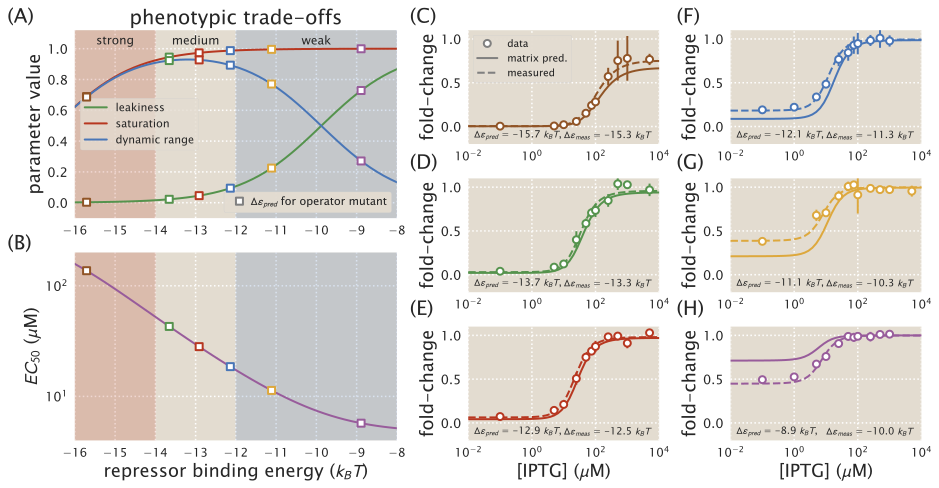

In [8]:
# Establish all parameter values
K_A = 139
K_I = 0.53
e_AI = 4.5
R=260
energies = np.linspace(-16, -8, 50)
op_list = ['O1new007', 'O1new012', 'O1new009', 'O1new010', 'O1new013', 'O1new014']
mut_list = ['mut007', 'mut012', 'mut009', 'mut010', 'mut013', 'mut014']
IPTG = np.logspace(-8, -2, 50)/1E-6
temp_colors=sns.color_palette(
    ['#905426', '#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b'])

# Choose entries to use from dataframe
op_logic = df_pred['matrix_operator'] == 'O1'
rep_logic = df_pred['matrix_repressor'] == 130

# Set up axes
fig = plt.figure(figsize=(13, 7))

ax0 = plt.subplot2grid((6, 7), (0, 0), colspan=3, rowspan=3)
ax1 = plt.subplot2grid((6, 7), (3, 0), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((6, 7), (0, 3), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 7), (2, 3), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((6, 7), (4, 3), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((6, 7), (0, 5), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((6, 7), (2, 5), colspan=2, rowspan=2)
ax7 = plt.subplot2grid((6, 7), (4, 5), colspan=2, rowspan=2)

axes_list = [ax2, ax3, ax4, ax5, ax6, ax7]

#########################################################################

# Plot ax0, ax1: Trade-offs of phenotypic parameters

# Plot properties of induction curves
ax0.plot(energies, sortseq.leakiness(K_A, K_I, e_AI, R, energies), label='leakiness', color=colors_qual[0])
ax0.plot(energies, sortseq.saturation(K_A, K_I, e_AI, R, energies), label='saturation', color=colors_qual[1])
ax0.plot(energies, sortseq.dynamic_range(K_A, K_I, e_AI, R, energies), label='dynamic range', color=colors_qual[2])

ax0.set_ylabel('parameter value')
ax0.set_xlim(-16, -8)
ax0.set_ylim(-0.1, 1.12)
ax0.set_title('phenotypic trade-offs')


# Add "high," "medium," and "low" regimes
ax0.fill_between([-16, -14], -1, 2, color=colors_qual[1], alpha=0.2)
ax0.fill_between([-12, -8], -1, 2, color=colors_qual[2], alpha=0.2)
ax0.text(-15, 1.05, 'strong', ha='center', va='center', fontsize=12)
ax0.text(-13, 1.05, 'medium', ha='center', va='center', fontsize=12)
ax0.text(-10, 1.05, 'weak', ha='center', va='center', fontsize=12)

# Add legend
ims = []

ims.append(mlines.Line2D([], [], marker='s', markeredgewidth=2,\
                         markerfacecolor='white', markeredgecolor='gray',\
                         label=r'$\Delta \varepsilon_{pred}$ for operator mutant', linestyle='None'))
ax0.add_artist(ax0.legend(fontsize=11, loc='center left'))
ax0.add_artist(ax0.legend(handles=ims, loc='lower right', handletextpad=0, fontsize=11))

# Plot ax1, EC50

ax1.plot(energies, sortseq.EC50(K_A, K_I, e_AI, R, energies), color=colors_qual[4])
ax1.set_xlim(-16, -8)
ax1.set_ylim(4, 200)
ax1.set_ylabel(r'$EC_{50}$ ($\mu$M)')
ax1.set_xlabel(r'repressor binding energy ($k_BT$)')
ax1.set_yscale('log')

# Add "high," "medium," and "low" regimes
ax1.fill_between([-16, -14], 1, 1000, color=colors_qual[1], alpha=0.2)
ax1.fill_between([-12, -8], 1, 1000, color=colors_qual[2], alpha=0.2)

# Add markers for chosen energy predictions
for j, mut in enumerate(mut_list):
    ax0.plot(df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0],\
             sortseq.leakiness(K_A, K_I, e_AI, R,\
                       df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0]),\
                 marker='s', markeredgecolor=temp_colors[j], markerfacecolor='white', markeredgewidth=2, zorder=9)
    ax0.plot(df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0],\
             sortseq.saturation(K_A, K_I, e_AI, R,\
                       df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0]),\
                 marker='s', markeredgecolor=temp_colors[j], markerfacecolor='white', markeredgewidth=2, zorder=9)
    ax0.plot(df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0],\
             sortseq.dynamic_range(K_A, K_I, e_AI, R,\
                       df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0]),\
                 marker='s', markeredgecolor=temp_colors[j], markerfacecolor='white', markeredgewidth=2, zorder=9)
    ax1.plot(df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0],\
             sortseq.EC50(K_A, K_I, e_AI, R,\
                       df_pred['energy_prediction'][(df_pred['mutant']==op_list[j]) & op_logic & rep_logic].values[0]),\
                 marker='s', markeredgecolor=temp_colors[j], markerfacecolor='white', markeredgewidth=2, zorder=9)

lines=[]

#########################################################################

# Plot ax2-ax7: IPTG titraton data and predicted titration curves

# Plot predictions/data for induction curves
for i, mut in enumerate(mut_list):
    axes_list[i].errorbar(mean_fc['IPTG_uM'][mean_fc['operator']==op_list[i]],\
             mean_fc['fold_change_A'][mean_fc['operator']==op_list[i]],\
                   yerr=std_fc['fold_change_A'][std_fc['operator']==op_list[i]],\
             ls = '', color=temp_colors[i], marker='o', markeredgecolor=temp_colors[i],\
                   markerfacecolor='white', markeredgewidth=2, zorder=9)
    temp, = axes_list[i].plot(IPTG, sortseq.fold_change(IPTG, K_A, K_I, e_AI, R,\
            df_pred['energy_measurement'][(df_pred['mutant']==op_list[i]) & op_logic & rep_logic].values[0]),\
             color=temp_colors[i], ls='--')
    temp, = axes_list[i].plot(IPTG, sortseq.fold_change(IPTG, K_A, K_I, e_AI, R,\
            df_pred['energy_prediction'][(df_pred['mutant']==op_list[i]) & op_logic & rep_logic].values[0]),\
             color=temp_colors[i])
    lines.append(temp,)
    
    measured = df_pred['energy_measurement'][(df_pred['mutant']==op_list[i]) & op_logic & rep_logic].values[0]
    predicted = df_pred['energy_prediction'][(df_pred['mutant']==op_list[i]) & op_logic & rep_logic].values[0]
    axes_list[i].set_xlim(1E-2, 1E4)
    axes_list[i].set_ylim(-0.2, 1.1)
    axes_list[i].set_xscale('log')
    axes_list[i].set_ylabel('fold-change')
    axes_list[i].text(1.5E-2, -0.1, r'$\Delta \varepsilon_{pred}$ = %0.1f $k_BT$,' % predicted, va='center')
    axes_list[i].text(1E1, -0.1, r'$\Delta \varepsilon_{meas}$ = %0.1f $k_BT$' % measured, va='center')
ax4.set_xlabel(r'[IPTG] ($\mu$M)')
ax7.set_xlabel(r'[IPTG] ($\mu$M)')

# Add legend

names = ['data', 'matrix pred.', 'measured']
ims = []
ims.append(mlines.Line2D([], [], marker='o', markeredgewidth=2,\
                         markerfacecolor='white', markeredgecolor='gray',\
                         label=names[0], linestyle='None'))
ims.append(mlines.Line2D([], [], linestyle='-', color='gray',\
                         label=names[1]))
ims.append(mlines.Line2D([], [], linestyle='--', color='gray',\
                         label=names[2]))
ax2.add_artist(ax2.legend(handles=ims, loc='upper left', handletextpad=1, fontsize=10))


# Label figures 
fig.text(0, 0.95, '(A)', fontsize=20)
fig.text(0, 0.5, '(B)', fontsize=20)
fig.text(0.43, 0.95, '(C)', fontsize=20)
fig.text(0.43, 0.66, '(D)', fontsize=20)
fig.text(0.43, 0.37, '(E)', fontsize=20)
fig.text(0.715, 0.95, '(F)', fontsize=20)
fig.text(0.715, 0.66, '(G)', fontsize=20)
fig.text(0.715, 0.37, '(H)', fontsize=20)

plt.tight_layout()